In [16]:
from google.colab import drive
import pandas as pd
import pickle

drive.mount('/content/drive')


file_path_ori = '/content/drive/My Drive/GDG_ML_WING_DATASET/preprocesss_dataset.csv'
# file_path_top = '/content/drive/My Drive/GDSC_DATASET/topline_result.dat'
# file_path_base = '/content/drive/My Drive/GDSC_DATASET/baseline_result.dat'
TOP_info = 0
base_info = 0
try:
    with open(file_path_ori, 'r') as f:
        DATA = pd.read_csv(file_path_ori)
    # with open(file_path_top, 'rb') as f:
    #     TOP_info = pickle.load(f)
    # with open(file_path_base, 'rb') as f:
    #     base_info = pickle.load(f)
except FileNotFoundError:
    print("File NOT FOUND. Check the path and filename.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Separate features and target
y = DATA["role"]
X = DATA.drop(columns=["role", "index"], errors="ignore")  # drop target + unnecessary columns

In [22]:
from sklearn.model_selection import train_test_split
X_filtered = X.copy()
y_filtered = y.copy()

# Ensure test size is at least equal to number of classes
num_classes = y_filtered.nunique()
min_test_size = num_classes / len(y_filtered)  # fraction required to cover all classes

# pick the larger between 20% and min_test_size
test_size = max(0.2, min_test_size)

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=test_size, random_state=42, stratify=y_filtered
)

print(f"✅ Split done with test_size={test_size:.2f}")
print("Train size:", len(y_train), " Test size:", len(y_test))
print("Unique classes in test set:", y_test.nunique(), "/", num_classes)

✅ Split done with test_size=0.20
Train size: 1200  Test size: 300
Unique classes in test set: 4 / 4


✅ SVM Accuracy: 0.8533

Classification Report:
              precision    recall  f1-score   support

     backend       0.84      0.84      0.84        97
    frontend       0.81      0.93      0.86        89
   fullstack       0.85      0.67      0.75        52
          qa       0.97      0.92      0.94        62

    accuracy                           0.85       300
   macro avg       0.87      0.84      0.85       300
weighted avg       0.86      0.85      0.85       300



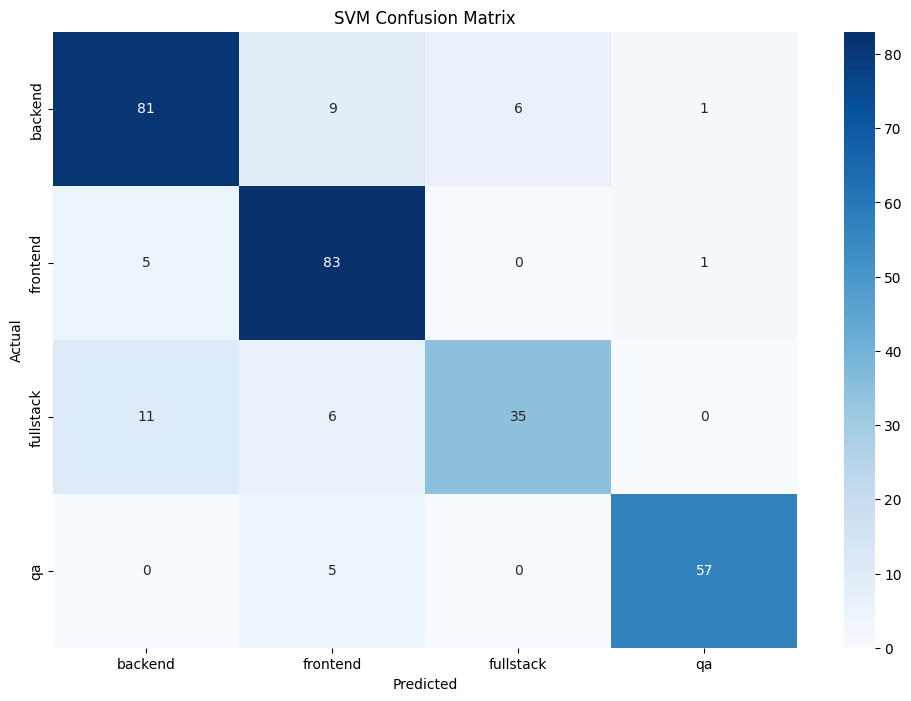

In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Identify categorical vs numeric columns
# --------------------------
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

# --------------------------
# Preprocessing pipeline
# --------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(with_mean=False), numeric_cols)  # keep sparse
    ]
)

# --------------------------
# Full pipeline with SVM
# --------------------------
svm_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel='linear', C=1, random_state=42))
])

# --------------------------
# Train
# --------------------------
svm_clf.fit(X_train, y_train)

# --------------------------
# Predict
# --------------------------
y_pred = svm_clf.predict(X_test)

# --------------------------
# Evaluation
# --------------------------
acc = accuracy_score(y_test, y_pred)
print(f"✅ SVM Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_clf.classes_,
            yticklabels=svm_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()
